In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

9.1 Classical hypothesis testing
---

The fundamental question we want to address is whether the effects we see
in a sample are likely to appear in the larger population. For example, in the
NSFG sample we see a difference in mean pregnancy length for first babies
and others. **We would like to know if that effect reflects a real difference for
women in the U.S., or if it might appear in the sample by chance**.

There are several ways we could formulate this question, including Fisher
null hypothesis testing, Neyman-Pearson decision theory, and Bayesian inference.

steps for classical hypothesis testing - 

- The first step is to quantify the size of the apparent effect by choosing a
test statistic. In the NSFG example, the apparent effect is a difference
in pregnancy length between first babies and others, so a natural choice
for the test statistic is the difference in means between the two groups.

- The second step is to define a null hypothesis, which is a model of the
system based on the assumption that the apparent effect is not real.
In the NSFG example the null hypothesis is that there is no difference
between first babies and others; that is, that pregnancy lengths for
both groups have the same distribution.

- The third step is to compute a p-value, which is the probability of
seeing the apparent effect if the null hypothesis is true. In the NSFG
example, we would compute the actual difference in means, then compute the probability of seeing a difference as big, or bigger, under the
null hypothesis.

- The last step is to interpret the result. If the p-value is low, the effect
is said to be statistically significant, which means that it is unlikely
to have occurred by chance. In that case we infer that the effect is
more likely to appear in the larger population.

9.2 Hypothesis test
----

example- 

suppose we toss a coin 250 times and see 140 heads
and 110 tails. Based on this result, we might suspect that the coin is biased;
that is, more likely to land heads. To test this hypothesis, we compute the
probability of seeing such a difference if the coin is actually fair

In [2]:
import random
def coin_toss(n):
    outcomes = []
    for _ in range(n):
        value = random.randint(0,1)
        outcomes.append(value)
    no_of_heads = len([x for x in outcomes if x==1])
    return abs((n-no_of_heads)-(no_of_heads))

coin_toss(100)

6

(array([249., 267., 209.,  94.,  90.,  41.,  22.,  20.,   2.,   6.]),
 array([ 0. ,  5.4, 10.8, 16.2, 21.6, 27. , 32.4, 37.8, 43.2, 48.6, 54. ]),
 <a list of 10 Patch objects>)

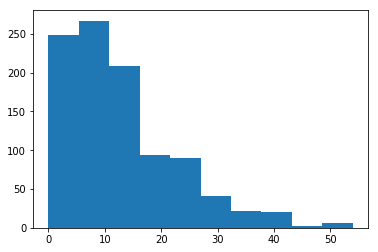

In [3]:
# simulation of 250 coins for 1000 times and plotting the distribution of difference between heads and tails
diff = []
for _ in range(1000):
    diff.append(coin_toss(250))

plt.hist(diff)

given a coin with 140 heads and 110 tails the probability of getting the difference of more than 30 - 

In [4]:
def p_value(n,iterations=1000):
    diff = []
    for _ in range(iterations):
        diff.append(coin_toss(n))
    occurence = len([x for x in diff if x>=30])
    return occurence/iterations

p_value(250)

0.063

the probability shows a value more than significant level i.e. 5%.
Hence we conclude that this difference is not significant. Hence the coin is unbiased.

But the choice of 5% is arbitrary, and (as we will see later) the p-value depends on the choice of the test statistics and the model of the null hypothesis.
So p-values should not be considered precise measurements

I recommend interpreting p-values according to their order of magnitude: if
the p-value is less than 1%, the effect is unlikely to be due to chance; if it is
greater than 10%, the effect can plausibly be explained by chance. P-values
between 1% and 10% should be considered borderline. So in this example I
conclude that the data do not provide strong evidence that the coin is biased
or not

9.3 Testing a mean difference
----

One of the most common effects to test is a difference in mean between two
groups. In the NSFG data, we saw that the mean pregnancy length for first
babies is slightly longer, and the mean birth weight is slightly smaller. Now
we will see if those effects are statistically significant.

 the null hypothesis is that the distributions for the two
groups are the same.

One way to model the null hypothesis is by permutation; 
- that is, we can take values for first babies and others and shuffle them,
- treating the two groups as one big group.

In [5]:
def nullHypothesis(series1,series2):
    pooled = np.hstack((series1,series2))
    np.random.shuffle(pooled)
    return pooled[:len(series1)],pooled[len(series1):]

In [6]:
# import the data
os.chdir(os.path.join('..','data'))
df = pd.read_csv(r'2002FemPreg.csv',low_memory=False)
df = df[['caseid','prglngth','outcome','pregordr','birthord','totalwgt_lb','agepreg','finalwgt']]
df = df[df['outcome']==1]
df = df.dropna()

In [26]:
first_babies = df[df['birthord']==1]['prglngth']
other_babies = df[df['birthord']!=1]['prglngth']
nullHypothesis(first_babies,other_babies)

(array([39, 39, 32, ..., 44, 37, 35]), array([39, 39, 39, ..., 39, 39, 39]))

In [27]:
# now compute the p-value
def p_value(xs,ys,mean,iterations=1000):
    diff = []
    for _ in range(iterations):
        group1,group2= nullHypothesis(xs,ys)
        mean_diff = abs(np.mean(group1) - np.mean(group2))
        diff.append(mean_diff)
    occurence = len([x for x in diff if x>=mean])
    return occurence/iterations

sample_mean_diff = abs(np.mean(first_babies) - np.mean(other_babies)) 

conclusion = '''which means that we expect to see a difference
as big as the observed effect about '''+str(p_value(first_babies,other_babies,sample_mean_diff))+''' of the time. So this effect is not
statistically significant.'''

print(conclusion)

which means that we expect to see a difference
as big as the observed effect about 0.164 of the time. So this effect is not
statistically significant.


from the simulations we can see that the difference is not very significant. Hence accept the null hypothesis.Saying that the difference might have occured by chance or in other words this difference doesnot belong to any new distribution.

If we run the same analysis with birth weight, the computed p-value is 0; after
1000 attempts, the simulation never yields an effect as big as the observed
difference, 0.12 lbs. So we would report p < 0:001, and conclude that the
difference in birth weight is statistically significant

9.4 Other test statistics
----

Choosing the best test statistic depends on what question you are trying to
address. For example, if the relevant question is whether pregnancy lengths
are different for first babies, then it makes sense to test the absolute difference
in means, as we did in the previous section.
If we had some reason to think that first babies are likely to be late, then
we would not take the absolute value of the difference; instead we would use
this test statistic:

In [9]:
def p_value_one_sided(mean,iterations=1000):
    diff = []
    for _ in range(iterations):
        group1,group2= nullHypothesis(first_babies,other_babies)
        mean_diff = np.mean(group1) - np.mean(group2)
        diff.append(mean_diff)
    occurence = len([x for x in diff if x>=mean])
    return occurence/iterations

mean=abs(np.mean(first_babies) - np.mean(other_babies))

conclusion = '''which means that we expect to see a difference
as big as the observed effect about **'''+str(p_value_one_sided(mean))+'''** of the time. So this effect is not
statistically significant.'''

print(conclusion)

which means that we expect to see a difference
as big as the observed effect about **0.101** of the time. So this effect is not
statistically significant.


The one-sided hypothesis, that first babies are born late, is more specific
than the two-sided hypothesis, so the p-value is smaller. But even for the
stronger hypothesis, the difference is not statistically significant.

In [10]:
def p_value_std(std,iterations=1000):
    diff = []
    for _ in range(iterations):
        group1,group2= nullHypothesis(first_babies,other_babies)
        std_diff = np.std(group1) - np.std(group2)
        diff.append(std_diff)
    occurence = len([x for x in diff if x>=std])
    return occurence/iterations

std=abs(np.std(first_babies) - np.std(other_babies))

conclusion = '''which means that we expect to see a difference
as big as the observed effect about **'''+str(p_value_std(std))+'''** of the time. So this effect is not
statistically significant.'''

print(conclusion)

which means that we expect to see a difference
as big as the observed effect about **0.046** of the time. So this effect is not
statistically significant.


9.5 Testing Correlations
---

the correlation between birth weight and mother’s age is about 0.07. It
seems like older mothers have heavier babies. But could this effect be due to
chance?

In [11]:
def pearson_coeff (x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    xmean = np.mean(x)
    ymean = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    xi = [(val-xmean)/std_x for val in x] 
    yi = [(val-ymean)/std_y for val in y]
    
    return sum(xi*np.transpose(yi))/len(x)

def spearman_coeff(x_series,y_series):
    rank1 = x_series.rank()
    rank2 = y_series.rank()
    return pearson_coeff(rank1,rank2)

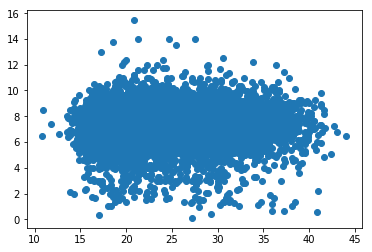

In [12]:
# variables
mothers_age = df['agepreg']
birth_wgt = df['totalwgt_lb']

plt.scatter(mothers_age,birth_wgt)

In [13]:
def p_value_corr(xs,ys,iters=1000):
    given_corr = pearson_coeff(xs,ys)
    coeffs = []
    for _ in range(iters):
        xs = np.random.permutation(xs)
        coeffs.append(abs(pearson_coeff(xs,ys)))
    
    return len([c for c in coeffs if c>=given_corr])/iters

p_value_corr(mothers_age.values,birth_wgt.values)       

0.0

In [14]:
np.random.permutation([1,2,3,4,5,6,7,8])

array([7, 3, 1, 4, 8, 5, 6, 2])

The actual correlation is 0.07. The computed p-value is 0; after 1000 iterations the largest simulated correlation is 0.04. So although the observed
correlation is small, it is statistically significant.

This example is a reminder that statistically significant" does not always
mean that an effect is important, or significant in practice. It only means
that it is unlikely to have occurred by chance.

9.6 Testing Propotions
----

In [15]:
import collections

def test_statistics(values):
    n = sum(values)
    fair_dice = np.ones(6,dtype=int)*(1/6*n)
    v = []
    for _ in range(n):
        v.append(np.random.randint(1,7))
    return sum(abs(np.array(list(collections.Counter(v).values())-fair_dice,dtype=int)))

values = [8,9,19,5,8,11]
test_statistics(values)

8

In [16]:
def dice_simulation(values,iters=1000):
    values = np.array(values)
    sum_diff =  sum(abs(values-np.ones(6)*(1/6*sum(values))))
    tests = []
    for _ in range(iters):
        tests.append(test_statistics(values))
    return len([x for x in tests if x >= sum_diff])/iters
    
dice_simulation(values)      

0.128

The p-value for this data is 0.13, which means that if the die is fair we expect
to see the observed total deviation, or more, about 13% of the time. So the
apparent effect is not statistically significant

9.7 Chi-square test
----

In the previous section we used total deviation as the test statistic. But for
testing proportions it is more common to use the chi-squared statistic:

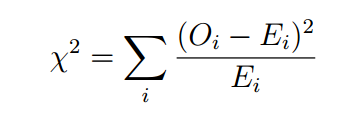

Where Oi are the observed frequencies and Ei are the expected frequencies.

Squaring the deviations (rather than taking absolute values) gives more
weight to large deviations. Dividing through by expected standardizes the
deviations

In [17]:
def chi_square_test_dice(values):
    n = sum(values)
    expected = np.ones(6,dtype=int)*(1/6*n)
    v = []
    for _ in range(n):
        v.append(np.random.randint(1,7))
    
    observed = np.array(list(collections.Counter(v).values()))
    chi_square = sum(((observed-expected)**2)/expected)
    return chi_square

def chi_square_test(observed,expected):
    return sum(((observed-expected)**2)/expected)

def chi_square_simulation(observed,expected,iters=1000):
    values = np.array(observed)
    sum_diff =  chi_square_test(observed,expected)
    tests = []
    for _ in range(iters):
        tests.append(chi_square_test_dice(values))
    return len([x for x in tests if x >= sum_diff])/iters

observed = [8,9,19,5,8,11] 
n = sum(observed)
expected = np.ones(6)*n/6

chi_square_simulation(observed,expected)

0.04

The p-value using the chi-squared statistic is 0.04, substantially smaller than
what we got using total deviation, 0.13. If we take the 5% threshold seriously,
we would consider this effect statistically significant. But considering the two
tests togther, I would say that the results are borderline. I would not rule out
the possibility that the die is crooked, but I would not convict the accused
cheater

This example demonstrates an important point: 

**the p-value depends on the
choice of test statistic and the model of the null hypothesis, and sometimes
these choices determine whether an effect is statistically significant or not**.

9.8 First Babies
-----

To see whether the differences between pregnancy length of both groups of babies are statistically
significant, we can use a test based on a chi-squared statistic

In [18]:
import collections
def calculate_freq(values):
    pmf = collections.Counter(values)
    return np.array([x for x in pmf.values()])

In [19]:
def null_hypothesis_prglength(series1,series2):
    data = np.hstack((series1,series2))
    np.random.shuffle(data)
    first,others = data[0:len(series1)],data[len(series1):]
    return first,others

def chi_squared_test(xs):
    # expected
    observed = calculate_freq(xs)
    n = len(observed) # number of possible outcomes
    expected = np.ones(n)/n*len(xs)
    return sum(((observed-expected)**2)/expected)

def test_statistics(first,others):
    return chi_squared_test(first)+chi_squared_test(others)

In [28]:
first_babies = [x for x in first_babies if x>=33 and x<44]
other_babies = [x for x in other_babies if x>=33 and x<44]

actual = test_statistics(first_babies,other_babies)
actual2 = 22020
def chi_square_simulation(test_statistic,iters=1000):
    chi_squares = []
    for _ in range(iters):
        first,others = null_hypothesis_prglength(first_babies,other_babies)
        chi_squares.append(test_statistics(first,others))
    p_value = len([x for x in chi_squares if x>=test_statistic])/iters
    return p_value
# p-value
chi_square_simulation(actual)

0.0

We conclude that the observed chi-squared
statistic is unlikely under the null hypothesis, so the apparent effect is statistically significant.

This example demonstrates a limitation of chi-squared tests: they indicate
that there is a difference between the two groups, but they don’t say anything
specific about what the difference is

9.9 Errors
---

If the effect is **actually due to chance (Null Hypothesis) -> Positive**, what is the probability that
we will wrongly consider it significant? This probability is the false
positive rate.

if the **effect is real (There is a significant difference -> Reject the null hypothesis -> hence test is negative)**, what is the chance that the hypothesis test will fail?
This probability is the false negative rate.

In classical hypothesis testing, an effect is considered statistically significant
if the p-value is below some threshold, commonly 5%. This procedure raises
two questions:
- If the effect is actually due to chance, what is the probability that
we will wrongly consider it significant? This probability is the false
positive rate.

-  the effect is real, what is the chance that the hypothesis test will fail?
This probability is the false negative rate.
The false positive rate is relatively easy to compute: if the threshold is 5%,
the false positive rate is 5%. Here’s why:

- If there is no real effect, the null hypothesis is true, so we can compute
the distribution of the test statistic by simulating the null hypothesis.
Call this distribution CDFT.

- Each time we run an experiment, we get a test statistic, t, which is
drawn from CDFT. Then we compute a p-value, which is the probability that a random value from CDFT exceeds t, so that’s 1 − CDFT(t).

- The p-value is less than 5% if CDFT(t) is greater than 95%; that is, if
t exceeds the 95th percentile. And how often does a value chosen from
CDFT exceed the 95th percentile? 5% of the time.

So if you perform one hypothesis test with a 5% threshold, you expect a false
positive 1 time in 20.

9.10 Powers
----
If the effect is real, what is the chance that the hypothesis test will fail?
This probability is the false negative rate.

**the false negative rate** is the proportion of positives which yield negative test outcomes with the test, i.e., the conditional probability of a negative test result **given that the condition being looked for is present**

The false negative rate is harder to compute because it depends on the actual
effect size, and normally we don’t know that. One option is to compute a
**rate conditioned on a hypothetical effect size**.

In [36]:
first_babies = df[df['birthord']==1]['prglngth']
other_babies = df[df['birthord']!=1]['prglngth']

def false_negative(xs,ys,n=100):
    count = 0
    for _ in range(n):
        sample1 = np.random.choice(xs,replace=True,size=len(xs))
        sample2 = np.random.choice(ys,replace=True,size=len(ys))
        
        mean_diff = abs(np.mean(sample1) - np.mean(sample2))
        p = p_value(sample1,sample2,mean_diff,iterations=101)
        if p > 0.05:  
        #  counting number of times the occurence of negative test given that there is significant differece
            count+=1   
    return count/n 
false_negative(first_babies,other_babies)

0.71

This the power of the test. It reflects the ability of the test to detect an effect. This means that around 30% of the time the test predicts the effect positively. Also known as **correct positive rate / power of the test**.

*Positive* is what we expect i.e. *Null Hypothesis* and *Negative* is what we dont i.e. *Alternative Hypothesis*.

As a rule of thumb, a
**power of 80% is considered acceptable**, so we would say that this test was
underpowered.

In general a negative hypothesis test does not imply that there is no difference
between the groups; instead it suggests that if there is a difference, it is too
small to detect with this sample size.

Power is the probability that a test correctly rejects a false null hypothesis. A good test is one with low probability of committing a Type I error (i.e., small α ) and high power (i.e., small β, high power). 

In [37]:
np.mean(first_babies) - np.mean(other_babies)

0.07511149297508268

9.11 Replication
----

"the repetition of the set of all the treatment combinations to be compared in an experiment. Each of the repetitions is called a replicate."

The hypothesis testing process I demonstrated in this chapter is not, strictly
speaking, good practice.

First, I performed multiple tests. If you run one hypothesis test, the chance
of a false positive is about 1 in 20, which might be acceptable. But if you
run 20 tests, you should expect at least one false positive, most of the time.

Second, I used the same dataset for exploration and testing. If you explore a
large dataset, find a surprising effect, and then test whether it is significant,
you have a good chance of generating a false positive.

To compensate for multiple tests, you can adjust the p-value threshold (see
https://en.wikipedia.org/wiki/Holm-Bonferroni_method). Or you can
address both problems by partitioning the data, using one set for exploration
and the other for testing.

 Typically the first paper to report a new result is considered exploratory. Subsequent papers that replicate the result with new data are
considered confirmatory.